# Import modules

In [1]:
# From the repository
from util import *
from read_data import *
data_names = list(name2file_name.keys())
print(data_names)

# Basic modules
import os
import glob
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# power law related
import powerlaw
import scipy
from scipy.optimize import minimize
import scipy.optimize as optimize
from sys import float_info
from numpy import tile
from numpy import exp, log

['blogcatalog', 'homosapiens', 'wikipos', 'enron', 'unvote', 'untrade', 'uslegis_net', 'uslegis_net_small_dyn', 'uslegis_net_dyn', 'uslegis_hyp_dyn', 'contacts', 'dawn_net', 'dawn_hyp', 'ndc_net', 'ndc_hyp', 'coauth_dblp_net', 'coauth_dblp_hyp', 'wiod2016', 'wiod2013', 'wiodlong', 'eth', 'bitcoinalpha', 'bitcoinotc', 'uscourt']


# Choose data

In [2]:
#name = "wiod2016"
name = data_names[-1]
print("We are going to use: " + name)

We are going to use: uscourt


In [3]:
# Enable original_format to use the format as originally provided
data_dict = get_data(name,original_format=False)
data_dict.keys()

dict_keys(['df_edges', 'df_nodes'])

In [4]:
#df_nodes = data_dict["df_nodes"]
df_edges = data_dict["df_edges"]

In [5]:
df_edges

source   target  weight
0       109382  2186852       4
1       104321  1561296       3
2       112903  1561296       3
3      2430249  1561296       3
4      1713584  1561296       1
...        ...      ...     ...
36545   109935  1060945       1
36546   109532  1060945       1
36547   109533  1060945       1
36548   109535  1060945       1
36549   111092  1060945       1

[36550 rows x 3 columns]

# Transform data

In [6]:
# Out degree
df_edges['count'] = df_edges.groupby(["source"])['source'].transform('size')
df_out = pd.DataFrame(df_edges[["source","count"]])
df_out.drop_duplicates(inplace=True)
# Calculating empirical distribution function
df_out.sort_values(by="count",ascending=False,inplace=True)
df_out["rank"] = range(1,len(df_out)+1)
df_out["prob"] = df_out["rank"] / len(df_out)

# in degree
df_edges['count'] = df_edges.groupby(["target"])['target'].transform('size')
df_in = pd.DataFrame(df_edges[["target","count"]])
df_in.drop_duplicates(inplace=True)
# Calculating empirical distribution function
df_in.sort_values(by="count",ascending=False,inplace=True)
df_in["rank"] = range(1,len(df_in)+1)
df_in["prob"] = df_in["rank"] / len(df_in)

# Histogram

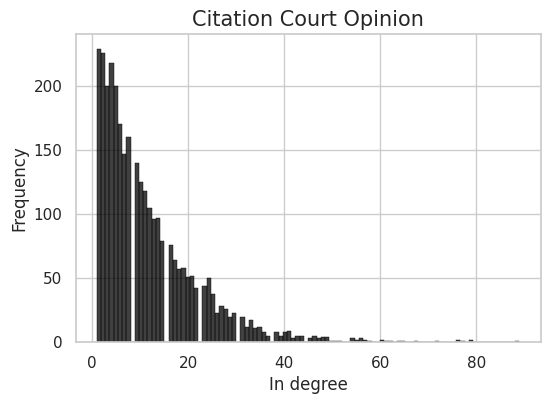

In [7]:
# Set the style of seaborn for better visualization
sns.set(style='whitegrid')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the histogram with seaborn styling
sns.histplot(df_in["count"], bins=100, kde=False, color='black', edgecolor='black', ax=ax)

# Customize the plot
ax.set_title('Citation Court Opinion', fontsize=15)
ax.set_xlabel('In degree', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Display the plot
plt.show()

# Empirical Complementary Cumulative Distribution Function

CPU times: user 22.5 ms, sys: 2.08 ms, total: 24.6 ms
Wall time: 21.1 ms


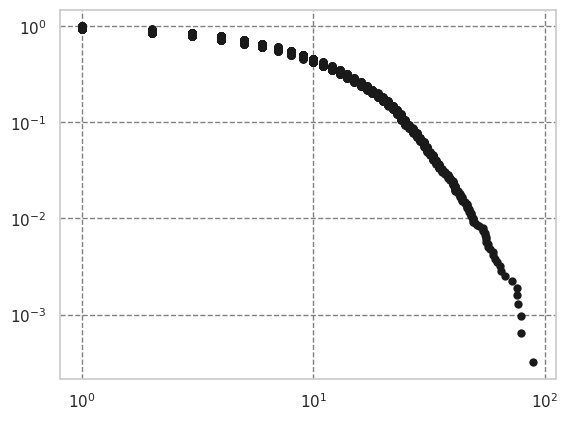

In [8]:
%%time
x = np.asarray(df_in["count"])
y = np.asarray(df_in["prob"])

fig = plt.figure()
ax = plt.gca()
plt.grid(which='major',color='grey',linestyle='--')
ax.plot(x,y,
        'o', c='k', alpha=1.0, markeredgecolor='none',)
ax.set_yscale('log')
ax.set_xscale('log')

# Power-law fit

In [9]:
# Out degree
data = df_in["count"].copy()
fit = powerlaw.Fit(data)

# Fit power law here
alpha = fit.power_law.alpha
x_min = fit.power_law.xmin

# Restrict to data above x_min
cond = df_in["count"] > x_min
df_tmp = df_in.loc[cond].copy()

Calculating best minimal value for power law fit


In [10]:
# Some definitions 
def power_fit(C):
    val = (df_tmp["prob"] - C*df_tmp["count"] **(-alpha+1))**2
    return sum(val) 

def power_cdf(C,alpha):
    return C*data **(-alpha+1) 

def lognorm_pdf(x_in):
    mu = x_in[0]
    sigma = x_in[1]
    total = - log(data) - log(sigma) - ( (log(data) - mu)**2 )/(2*sigma**2)
    return sum(-total)

def lognorm_cdf(mu,sigma):
    val = 0.5 * ( 1 + scipy.special.erf(
        (np.log(data) - mu) / (sigma * np.sqrt(2))
    ))
    return 1 - val


print(power_fit(1))
print(power_fit(3))

# lazy method to find the normalizing constant
x0 = np.array(1)
res_1 = optimize.minimize(power_fit, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

C = res_1.x[0]

#fit.xmax = 500000
x0 = np.array([1,2])
res_1 = optimize.minimize(lognorm_pdf, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})



0.49502996611844524
0.4949091623822363
Optimization terminated successfully.
         Current function value: 0.001068
         Iterations: 59
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 7909.846232
         Iterations: 68
         Function evaluations: 136


# Since we are using only a subset of the data it seems that the lognormal fit is not that bad

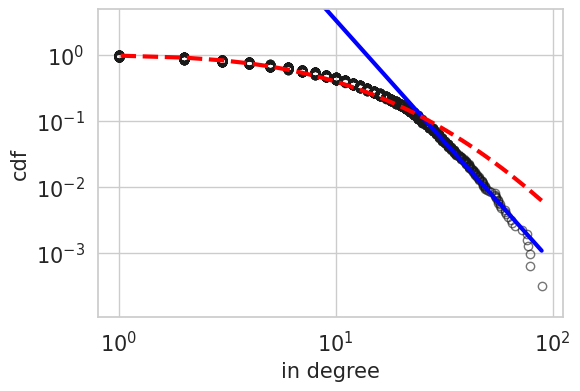

In [11]:
# plot empirical distribution
plt.figure(figsize=(6,4))
x = np.asarray(df_in["count"])
y = np.asarray(df_in["prob"])
plt.plot(x,y,"k",linestyle="",marker="o",markersize=6,fillstyle="none",alpha=0.6)

# plot power law fit
x = np.asarray(data)
y = np.asarray(power_cdf(C,alpha))
plt.plot(x,y,color="blue",linewidth=3)
plt.xscale("log")
plt.yscale("log")
plt.ylim(df_in["prob"].iloc[0]/3,5)

# plot lognormal fit
x = np.asarray(df_in["count"])
y = np.asarray(lognorm_cdf(res_1.x[0],res_1.x[1]))
plt.plot(x,y,linestyle="--",color="red",linewidth=3)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("in degree",size=15)
plt.ylabel("cdf",size=15)
plt.savefig("./figures/2021_6_1_in_degree_subset.pdf",bbox_inches="tight")

# For your information

In [12]:
%%time
# Read the raw data
df_edges = pd.read_csv("./data/citation-map-2022-12-31.csv")
df_edges.columns = ["index","depth","target","source"]

CPU times: user 15.2 s, sys: 954 ms, total: 16.1 s
Wall time: 16.1 s


In [13]:
# out degree
df_edges['count'] = df_edges.groupby(["source"])['source'].transform('size')
df_out = pd.DataFrame(df_edges[["source","count"]])
df_out.drop_duplicates(inplace=True)
# Calculating empirical distribution function
df_out.sort_values(by="count",ascending=False,inplace=True)
df_out["rank"] = range(1,len(df_out)+1)
df_out["prob"] = df_out["rank"] / len(df_out)

# in degree
df_edges['count'] = df_edges.groupby(["target"])['target'].transform('size')
df_in = pd.DataFrame(df_edges[["target","count"]])
df_in.drop_duplicates(inplace=True)
# Calculating empirical distribution function
df_in.sort_values(by="count",ascending=False,inplace=True)
df_in["rank"] = range(1,len(df_in)+1)
df_in["prob"] = df_in["rank"] / len(df_in)

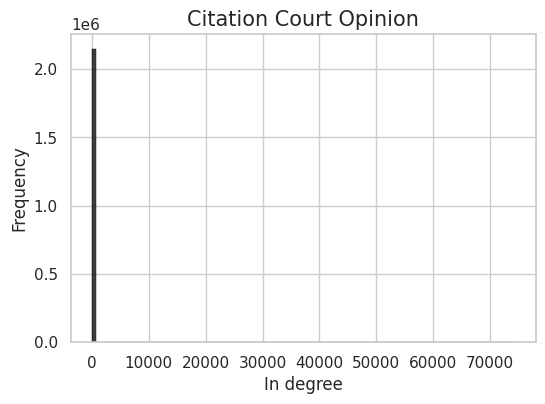

In [14]:
# Set the style of seaborn for better visualization
sns.set(style='whitegrid')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the histogram with seaborn styling
sns.histplot(df_in["count"], bins=100, kde=False, color='black', edgecolor='black', ax=ax)

# Customize the plot
ax.set_title('Citation Court Opinion', fontsize=15)
ax.set_xlabel('In degree', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Display the plot
plt.show()


CPU times: user 72.3 ms, sys: 11 ms, total: 83.3 ms
Wall time: 77.6 ms


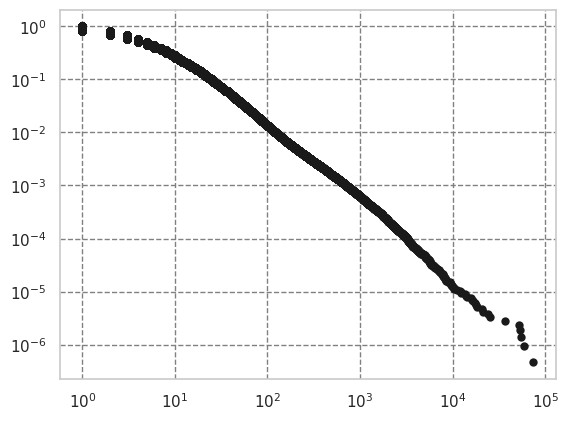

In [15]:
%%time
x = np.asarray(df_in["count"])
y = np.asarray(df_in["prob"])
fig = plt.figure()
ax = plt.gca()
ax.grid(which='major',color='grey',linestyle='--')
ax.plot(x,y,
        'o', c='k', alpha=1.0, markeredgecolor='none')
ax.set_yscale('log')
ax.set_xscale('log')

# Power law fit

In [16]:
# Out degree
data = df_in["count"]

# power law fit
fit = powerlaw.Fit(data)
alpha = fit.power_law.alpha
x_min = fit.power_law.xmin

# Restrcit to data above xmin
cond = df_in["count"] > x_min
df_tmp = df_in.loc[cond].copy()

Calculating best minimal value for power law fit


# It only shows the truncated version

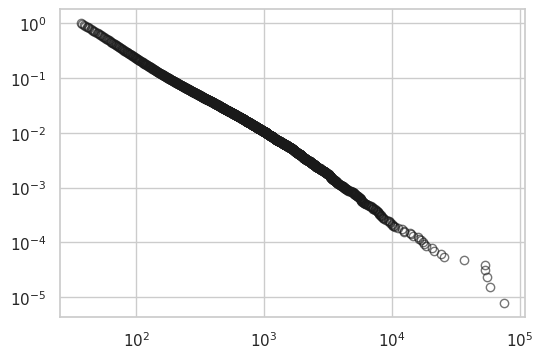

In [17]:
x = fit.ccdf()[0]
y = fit.ccdf()[1]
plt.figure(figsize=(6,4))
plt.plot(x,y,"k",linestyle="",marker="o",markersize=6,fillstyle="none",alpha=0.6)
plt.xscale("log")
plt.yscale("log")


# Integrate the fit into the original empirical distribution + lognormal

In [18]:
# Some auxli
def power_fit(C):
    val = (df_tmp["prob"] - C*df_tmp["count"] **(-alpha+1))**2
    return sum(val) 

def power_cdf(C,alpha):
    return C*data **(-alpha+1) 

def lognorm_pdf(x_in):
    mu = x_in[0]
    sigma = x_in[1]
    total = - log(data) - log(sigma) - ( (log(data) - mu)**2 )/(2*sigma**2)
    return sum(-total)

def lognorm_cdf(mu,sigma):
    val = 0.5 * ( 1 + scipy.special.erf(
        (np.log(data) - mu) / (sigma * np.sqrt(2))
    ))
    return 1 - val


# lazy method to find the normalizing constant
x0 = np.array(1)
res_1 = optimize.minimize(power_fit, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
C = res_1.x[0]

# fit eh lognormal distribution
x0 = np.array([1,2])
res_1 = optimize.minimize(lognorm_pdf, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})



Optimization terminated successfully.
         Current function value: 0.013786
         Iterations: 37
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 4934873.143457
         Iterations: 74
         Function evaluations: 169


# Plot figure

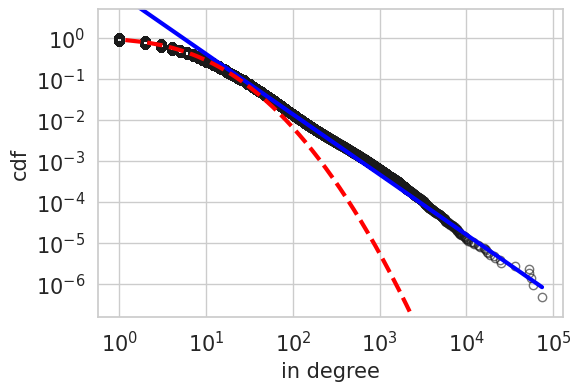

In [19]:
# plot empirical distribution
plt.figure(figsize=(6,4))
x = np.asarray(df_in["count"])
y = np.asarray(df_in["prob"])
plt.plot(x,y,"k",linestyle="",marker="o",markersize=6,fillstyle="none",alpha=0.6)

# plot power law fit
x = np.asarray(data)
y = np.asarray(power_cdf(C,alpha))
plt.plot(x,y,color="blue",linewidth=3)
plt.xscale("log")
plt.yscale("log")
plt.ylim(df_in["prob"].iloc[0]/3,5)

# plot lognormal fit
x = np.asarray(df_in["count"])
y = np.asarray(lognorm_cdf(res_1.x[0],res_1.x[1]))
plt.plot(x,y,linestyle="--",color="red",linewidth=3)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("in degree",size=15)
plt.ylabel("cdf",size=15)

# save to file
plt.savefig("./figures/2021_6_1_in_degree.pdf",bbox_inches="tight")